In [1]:
import numpy as np
import pandas as pd

# from concurrent.futures import ProcessPoolExecutor, as_completed
# from tqdm.notebook import tqdm

from functools import partial
from jax import random

import numpyro
import pickle
import os

from numpyro.infer import MCMC, NUTS, init_to_median

# from numpyr.infer import Trace_ELBO, SVI, autoguide, init_to_value,  Predictive
# from numpyro.infer.reparam import LocScaleReparam
import arviz as az

from matplotlib import pyplot as plt

In [2]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.85"
numpyro.set_platform("gpu")
numpyro.set_host_device_count(3)

In [3]:
from refit_fvs.models.diameter_growth import wykoff_model

model = partial(
    wykoff_model,
    pooling="pooled",
    num_cycles=10,
    bark_b1=0.903563,
    bark_b2=0.989388,
    plot_random=True,
    loc_random=True,
)

MODEL_NAME = "wykoff_pooled_mixed"

In [4]:
FIA = "../../data/interim/FIA_remeasured_trees_for_training.csv"
fia = pd.read_csv(FIA)
fia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 63 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   STATECD            290429 non-null  int64  
 1   UNITCD             290429 non-null  int64  
 2   COUNTYCD           290429 non-null  int64  
 3   PLOT               290429 non-null  int64  
 4   PLOT_ID            290429 non-null  int64  
 5   SUBPLOT            290429 non-null  int64  
 6   SUBPLOT_ID         290429 non-null  int64  
 7   PLOT_CN            290429 non-null  int64  
 8   PLOT_CN_NEXT       290429 non-null  int64  
 9   TREE_CN            220620 non-null  float64
 10  TREE_CN_NEXT       269952 non-null  float64
 11  TREE_ID            290429 non-null  int64  
 12  LAT                290429 non-null  float64
 13  LON                290429 non-null  float64
 14  ELEV               290429 non-null  float64
 15  VARIANT            290429 non-null  object 
 16  LO

In [5]:
RAW_COVARS = [
    "VARIANT",
    "LOCATION",
    "PLOT_ID",
    "SICOND",
    "SLOPE",
    "ELEV",
    "DBH",
    "CR",
    "CR_NEXT",
    "BAPALARGER",
    "BAPALARGER_NEXT",
    "PTBAPA",
    "PTBAPA_NEXT",
]
RAW_OBS = ["DBH_NEXT"]

MODEL_COVARS = [
    "VAR_IDX",
    "LOC_IDX",
    "PLOT_IDX",
    "SICOND",
    "SLOPE",
    "ELEV",
    "DBH",
    "CR_START",
    "CR_END",
    "COMP_TREE_START",
    "COMP_TREE_END",
    "COMP_STAND_START",
    "COMP_STAND_END",
]
MODEL_OBS = ["DG_OBS"]

DATE_COLS = ["MEASYEAR", "MEASMON", "MEASYEAR_NEXT", "MEASMON_NEXT"]

data = (
    fia.loc[
        (fia.FIA_SPCD == 202)
        & (fia.STATUSCD == 1)
        & (fia.STATUSCD_NEXT == 1)
        & ((fia.MEASYEAR_NEXT - fia.MEASYEAR) == 10)
    ]
    .dropna(subset=RAW_COVARS)[RAW_COVARS + RAW_OBS + DATE_COLS]
    .copy()
)

data["VAR_IDX"], obs_variants = pd.factorize(data["VARIANT"])
data["LOC_IDX"], obs_locations = pd.factorize(data["LOCATION"])
data["PLOT_IDX"], obs_plots = pd.factorize(data["PLOT_ID"])

data[["CR_START", "CR_END"]] = data[["CR", "CR_NEXT"]] / 100.0
data["COMP_TREE_START"] = data["BAPALARGER"] / np.log(data["DBH"] + 1.0)
data["COMP_TREE_END"] = data["BAPALARGER_NEXT"] / np.log(data["DBH_NEXT"] + 1.0)
data["COMP_STAND_START"] = np.log(data["PTBAPA"])
data["COMP_STAND_END"] = np.log(data["PTBAPA_NEXT"])
data["SLOPE"] = data["SLOPE"] / 100.0
data["ELEV"] = data["ELEV"] / 100.0
data["BAI_OBS"] = np.pi / 4 * (data["DBH_NEXT"] ** 2 - data["DBH"] ** 2)
data["DG_OBS"] = data["DBH_NEXT"] - data["DBH"]

data.describe()

,LOCATION,PLOT_ID,SICOND,SLOPE,ELEV,DBH,CR,CR_NEXT,BAPALARGER,BAPALARGER_NEXT,...,LOC_IDX,PLOT_IDX,CR_START,CR_END,COMP_TREE_START,COMP_TREE_END,COMP_STAND_START,COMP_STAND_END,BAI_OBS,DG_OBS
count,46640.000000,4.664000e+04,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,...,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000
mean,611.198928,4.128094e+11,106.895626,0.395567,27.590609,17.467607,51.262800,44.423756,23.615405,28.752976,...,18.693932,2866.127187,0.512628,0.444238,9.814363,11.616547,3.666147,3.970216,42.792888,1.580695
std,59.106089,1.351712e+11,40.223301,0.244512,14.377195,13.411414,20.933287,18.788598,23.029065,25.793249,...,11.718741,1579.582732,0.209333,0.187886,10.501975,11.836635,0.776441,0.584512,72.571571,1.454398
min,113.000000,6.010155e+10,19.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,-0.894381,0.329905,-8054.980732,-90.600000
25%,606.000000,4.101040e+11,71.000000,0.200000,15.000000,7.500000,35.000000,30.000000,6.268590,8.850594,...,8.000000,1370.000000,0.350000,0.300000,2.407283,3.056211,3.243782,3.655715,12.511393,0.700000
50%,612.000000,4.102020e+11,107.000000,0.380000,29.000000,11.900000,49.000000,40.000000,17.749218,23.346168,...,22.000000,3163.000000,0.490000,0.400000,7.006386,8.627338,3.762352,4.017366,31.227431,1.300000
75%,618.000000,5.306032e+11,138.000000,0.600000,37.000000,25.900000,65.000000,55.000000,34.420105,42.414120,...,29.000000,4191.000000,0.650000,0.550000,13.968688,16.818823,4.203204,4.358891,59.541035,2.200000
max,800.000000,5.309072e+11,223.000000,1.550000,77.000000,101.900000,99.000000,99.000000,192.072540,206.038192,...,43.000000,5551.000000,0.990000,0.990000,180.661061,236.552267,5.398964,5.885720,2826.483056,26.300000


In [6]:
# train_data = data.sample(frac=0.01)
train_data = data.copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46640 entries, 3 to 290390
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VARIANT           46640 non-null  object 
 1   LOCATION          46640 non-null  float64
 2   PLOT_ID           46640 non-null  int64  
 3   SICOND            46640 non-null  float64
 4   SLOPE             46640 non-null  float64
 5   ELEV              46640 non-null  float64
 6   DBH               46640 non-null  float64
 7   CR                46640 non-null  float64
 8   CR_NEXT           46640 non-null  float64
 9   BAPALARGER        46640 non-null  float64
 10  BAPALARGER_NEXT   46640 non-null  float64
 11  PTBAPA            46640 non-null  float64
 12  PTBAPA_NEXT       46640 non-null  float64
 13  DBH_NEXT          46640 non-null  float64
 14  MEASYEAR          46640 non-null  int64  
 15  MEASMON           46640 non-null  float64
 16  MEASYEAR_NEXT     46640 non-null  int64

In [7]:
model_args = []
model_kwargs = dict(
    data=[train_data[col].values for col in MODEL_COVARS],
    y=train_data["DG_OBS"].values,
    num_variants=len(obs_variants),
    num_locations=len(obs_locations),
    num_plots=len(obs_plots),
)

In [8]:
%%time
train_data["VAR_IDX"], obs_variants = pd.factorize(train_data["VARIANT"])
train_data["LOC_IDX"], obs_locations = pd.factorize(train_data["LOCATION"])
train_data["PLOT_IDX"], obs_plots = pd.factorize(train_data["PLOT_ID"])

nuts_kernel = NUTS(
    model=model,
    dense_mass=[
        ("b0z", "b3z"),  # intercept and site index
        ("b1z", "b2z"),  # ln(dbh) and dbh**2
        ("b7z", "b8z"),  # competition effects
    ],
    init_strategy=init_to_median,
)

mcmc = MCMC(
    nuts_kernel,
    progress_bar=True,
    num_chains=3,
    chain_method="parallel",
    num_warmup=1000,
    num_samples=1000,
)

mcmc.run(
    random.PRNGKey(1),
    *model_args,
    **model_kwargs,
)
# warmup=1000, samples=1000, chains=3, n=46640
# CPU times: user 3h 31min 24s, sys: 6.83 s, total: 3h 31min 31s
# Wall time: 1h 10min 47s

/opt/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/jax/linear_util.py:168: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))


CPU times: user 3h 31min 24s, sys: 6.83 s, total: 3h 31min 31s
Wall time: 1h 10min 47s


In [9]:
with open(f"../../models/mcmc/{MODEL_NAME}.pkl", "wb") as f:
    pickle.dump((mcmc), f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0z     -1.91      0.05     -1.91     -1.98     -1.84   1263.80      1.00
        b1z      0.78      0.01      0.78      0.77      0.79   2390.86      1.00
        b2z     -0.21      0.01     -0.21     -0.22     -0.21   2656.96      1.00
        b3z      0.30      0.00      0.30      0.29      0.30   1271.44      1.00
        b4z     -0.05      0.00     -0.05     -0.05     -0.04   1559.63      1.00
        b5z     -0.09      0.00     -0.09     -0.10     -0.08   1160.02      1.00
        b6z      0.37      0.00      0.37      0.37      0.38   2421.55      1.00
        b7z     -0.37      0.00     -0.37     -0.37     -0.36   2645.68      1.00
        b8z      0.07      0.00      0.07      0.07      0.08   2513.15      1.00
    eloc[0]     -0.23      0.02     -0.23     -0.25     -0.20   2029.52      1.00
    eloc[1]     -0.17      0.03     -0.17     -0.22     -0.11   2400.65      1.00
    eloc[2]    

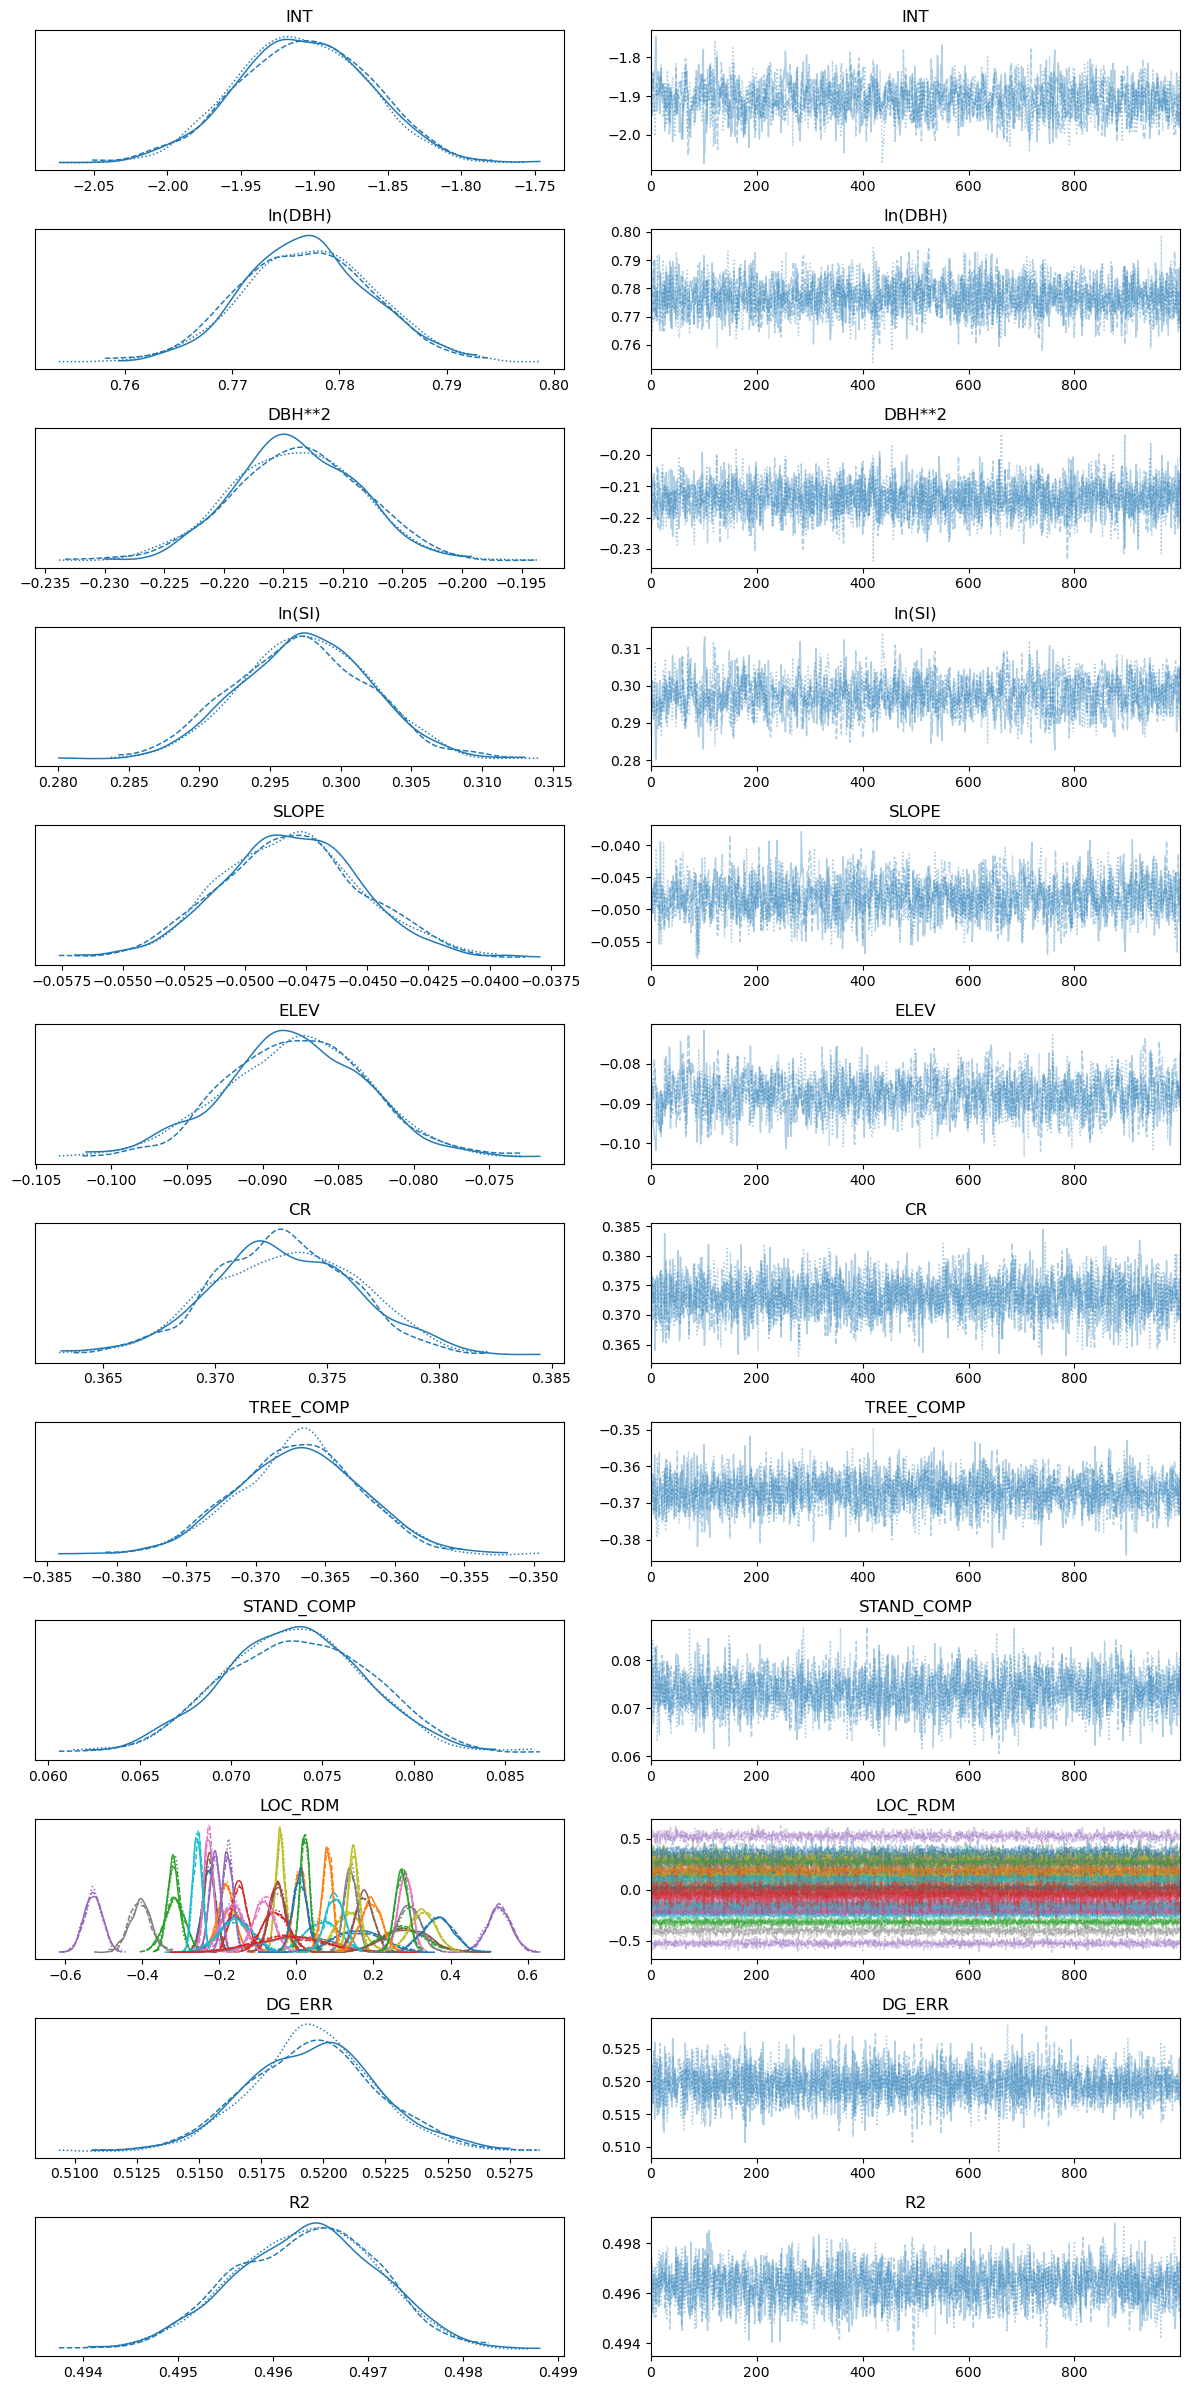

In [11]:
az_ = az.from_numpyro(mcmc)
VAR_NAMES = [
    "b0z",
    "b1z",
    "b2z",
    "b3z",
    "b4z",
    "b5z",
    "b6z",
    "b7z",
    "b8z",
    "eloc",  # 'eplot',
    "etree_dg",
    "dg_r2",
]
VAR_LABELS = [
    "INT",
    "ln(DBH)",
    "DBH**2",
    "ln(SI)",
    "SLOPE",
    "ELEV",
    "CR",
    "TREE_COMP",
    "STAND_COMP",
    "LOC_RDM",  # 'PLOT_RDM',
    "DG_ERR",
    "R2",
]
axs = az.plot_trace(az_, var_names=VAR_NAMES)
for i, _ in enumerate(axs[:, 0]):
    label = VAR_LABELS[i]
    axs[i, 0].set_title(label)
    axs[i, 1].set_title(label)

plt.tight_layout()
plt.show()

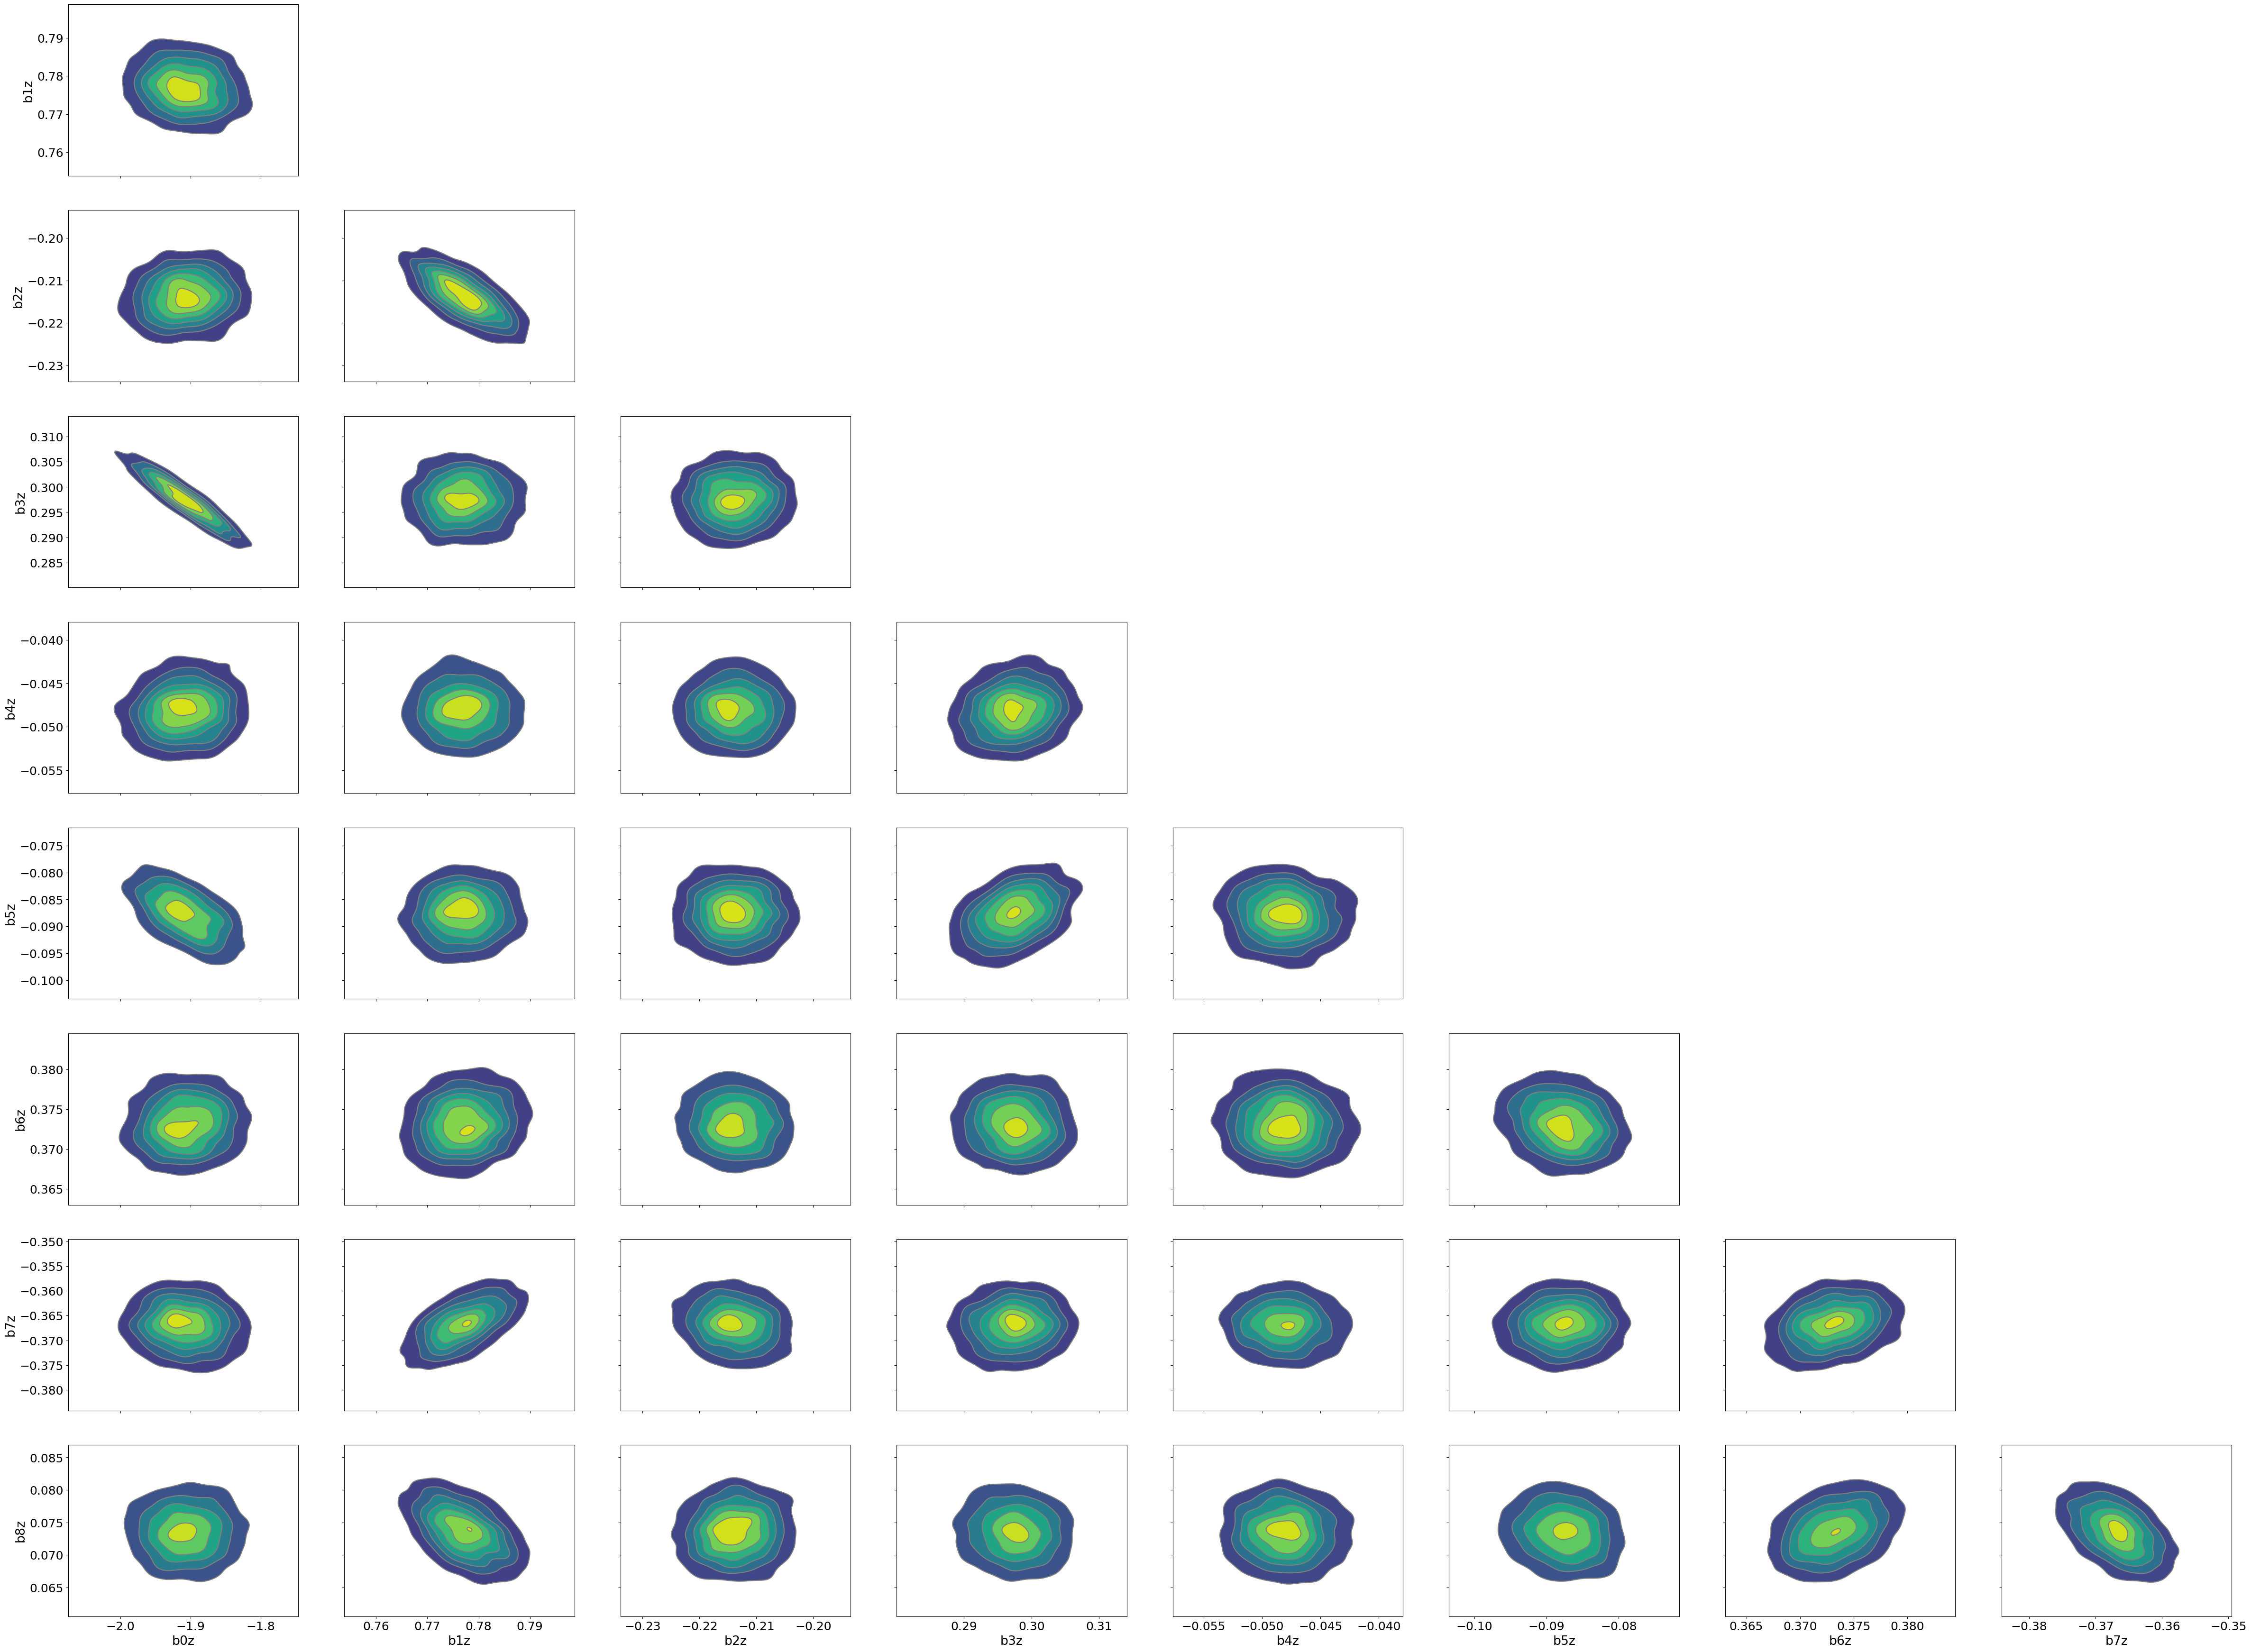

In [12]:
az.plot_pair(az_, var_names=VAR_NAMES[0:9], kind="kde", divergences=True, textsize=18);

In [ ]:
os._exit(00)